# Amazon Reviews - Graphing Predictions for Analysis

In the previous stages of our data science pipeline, we've developed insights into the structure of our Amazon Reviews data, how NLP techniques can be used to classify different attributes (e.g. Product Category), and how we can then take the most appropriate method and scale it up.

We're now going to look at how we can use a simple graph to to develop a graphed version of the dataset we're exploring, and then use specific queries to retrieve analytical insights, which combine the predictions and the original datasets.

In the following example we're going to be using a `ruruki` as a lightweight python implementation of a graph database, however, the same methodology can be applied to more robust solutions such as Amazon [Neptune](https://aws.amazon.com/neptune/)

**Graph Structure**

We're going to create the following network structure to begin with, and combine the original attributes of the dataset (reviews, customers, products, product categories), with the output from our predicted product category.

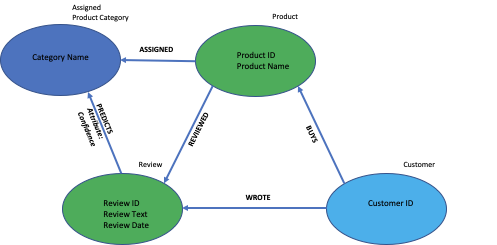

### Imports

The following imports are required in order to run different statistical tests and modelling techniques.

In [1]:
# NOTE: Uncomment the folllowing lines on first run of the notebook.
# !pip install --upgrade pip
# !pip install ruruki
# !pip install pyvis

In [41]:
import boto3
import sagemaker
from s3_concat import S3Concat
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk
from fastparquet import write
from fastparquet import ParquetFile
import s3fs
import pyarrow.parquet as pq
import pickle
import glob
import ast 
import csv
import itertools
import dask.dataframe as dd
from dask.multiprocessing import get
import multiprocessing
import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics


from ruruki.graphs import Graph
import pyvis
from pyvis.network import Network

### Configs and Global Vars

Throughout the notebook we're going to store all our global variables (although all variables inside a notebook are global if they are not defined in a method), inside an array.

In [168]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews_csvs', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' :'.csv',
    'wordvecdata': 'wordvec-full-data',
    'models_dir': 'models',
    'label_column':'product_category',
    'text_column': 'review_body_processed',
    'class_labels_pickle_filename':'class_labels.pkl',
    'bt_model_name':'blazingtext-2020-05-11-09-42-44-125'

}

In [38]:
#initilize empty
global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [39]:
def setup_env(configs, global_vars):
    sess = sagemaker.Session()
    role = get_execution_role()
    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')
    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [40]:
def create_dataset_manifest(configs, global_vars):
    interval_printer_idx = 100
    idx = 0
    1
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    manifest = []    
    for file in conn.objects.filter(Prefix=s3_prefix):
        path = file.key
#         print(file)
        if (file_format in path):
#             print(path)
            relative_path = path.replace(configs['prefix'],'')
            date = relative_path.split('/')[1].replace(index_key,'')

            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path, 'date':date}
            manifest.append(man)  
            idx += 1
            if (idx % interval_printer_idx) == 0:
                print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

Processed 100 files
Processed 200 files
Training Dataset Size 241


### Download Sample Data

In [45]:
def download_sample(configs, global_vars, manifest):
    
    entry = manifest[100]
    ile_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    date = entry['path'].split('/')[1].replace(index_key,'')
    #get the meta data 
    full_path = 's3://'+configs['bucket_name']+'/'+entry['path_with_prefix']
    df = pd.read_csv(full_path, header=0, error_bad_lines=False, escapechar="\\")
    print(date, df.shape)
    return df

sample_data = download_sample(configs, global_vars, manifest)  

b'Skipping line 79951: expected 18 fields, saw 22\n'


2003-12 (96123, 18)


In [170]:
sample_data.head(2)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category,body_len,review_body_processed
0,US,32929367,R2AYE93KTPIQFD,B00009WAUO,121192178,Super Mario Advance 4: Super Mario Bros 3,5,7,7,N,N,The Best Mario Advance Yet,Nintendo could learn a thing or so from its pa...,2003-12-09,2003,Video_Games,3263,"[nintendo, could, learn, thing, past, gamer, n..."
1,US,48492699,R3P8SM9UAG6ZJ4,B000067QD5,309256386,Xbox System Link Cable,1,21,25,N,N,Don't waste your money.,Have a techy friend make you a CAT 5 ethernet ...,2003-12-12,2003,Video_Games,136,"[techy, friend, make, cat, 5, ethernet, cable,..."


### Load the Pre-Trained Model and Class Labels

In [169]:
def load_endpoint(configs, global_vars):
    
    model =  sagemaker.RealTimePredictor(configs['bt_model_name'])
    global_vars['w2v_classifier'] = model
    return global_vars


#find the endpoint name from your AWS Console, configure in your conf
#load the endpoint
global_vars = load_endpoint(configs, global_vars)


In [174]:
def load_class_label_mapping(configs, global_vars):

    filename = configs['class_labels_pickle_filename']
    global_vars['labels'] = pickle.load( open(filename, "rb" ) )
    labels_inv = {y:x for x,y in global_vars['labels'].items()}
    global_vars['labels_inv'] = labels_inv
    print('Labels Loaded \n{}'.format(global_vars['labels']))
    
    return global_vars
    
global_vars = load_class_label_mapping(configs, global_vars)

Labels Loaded 
{'Books': 0, 'Video': 1, 'Music': 2, 'Video_DVD': 3, 'Toys': 4, 'Video_Games': 5, 'Office_Products': 6, 'PC': 7, 'Camera': 8, 'Kitchen': 9, 'Electronics': 10, 'Software': 11, 'Baby': 12, 'Wireless': 13, 'Home': 14, 'Health_&_Personal_Care': 15, 'Grocery': 16, 'Beauty': 17, 'Sports': 18, 'Home_Entertainment': 19, 'Apparel': 20, 'Shoes': 21, 'Tools': 22, 'Lawn_and_Garden': 23, 'Pet_Products': 24, 'Outdoors': 25, 'Digital_Music_Purchase': 26, 'Digital_Ebook_Purchase': 27, 'Home_Improvement': 28, 'Automotive': 29, 'Jewelry': 30, 'Mobile_Apps': 31, 'Digital_Video_Download': 32}


In [229]:
def predict_product_cat_label(model, labels, text_to_predict, is_text_tokenized=True):
    
#     print(labels)
    res = ''
    if is_text_tokenized:       
            res = str(text_to_predict).strip('][').split(', ') 
            res = ' '.join(res)
    else:
        res = text_to_predict
        
    payload = {"instances":[res],
                  "configuration": {"k": 1}}

#     print(payload)
    
    response = model.predict(json.dumps(payload))
    
#     print(response)
    
    lab_indx = int(json.loads(response)[0]['label'][0].replace('__label__',''))
    conf = float(json.loads(response)[0]['prob'][0])
    conf = round(conf, 3)
                 
    lab_string = labels[lab_indx]
        
    return lab_string, conf
    
predict_product_cat_label(global_vars['w2v_classifier'], global_vars['labels_inv'], '[this, is, a, book]', is_text_tokenized=True)


('Books', 1.0)

### Create Graph

In [597]:
#the following method isn't suitable for developing large graphs, need to iterate rather than collect them
def transform_data_to_graph(configs, global_vars, df):
    
    graph = Graph()
    
    EDGE_BOUGHT = 'BOUGHT'
    EDGE_ASSIGNED = 'ASSIGNED'
    EDGE_WROTE = 'WROTE'
    EDGE_PREDICTED = 'PREDICTED'
    EDGE_REVIEWED = 'REVIWED'

    
    #add constraints
    graph.add_vertex_constraint("product", "product_id")
    graph.add_vertex_constraint("customer", "customer_id")
    graph.add_vertex_constraint("review", "review_id")
#     graph.add_vertex_constraint("predicted_product_category", "name")
    graph.add_vertex_constraint("product_category", "name")
    
    #let's first get all the unique product categories and add them 
    unq_product_categories = set(df['product_category'].tolist())
    print(unq_product_categories)
    for prod_cat in unq_product_categories:
        
#         graph.get_or_create_vertex("predicted_product_category", name=prod_cat)
        graph.get_or_create_vertex("product_category", name=prod_cat)
    
    #iterate and add either vertexes or edges
    df = df.sample(frac=0.01)
    for idx,row in df.iterrows():
        
        customer = graph.get_or_create_vertex("customer", customer_id=row['customer_id'])
        product = graph.get_or_create_vertex("product", product_id=row['product_id'], product_name = row['product_title'])
        review = graph.get_or_create_vertex("review", 
                                            review_id=row['review_id'], 
                                            review_date=row['review_date'], 
                                            star_rating=row['star_rating'],
                                            review_text_processed=row['review_body_processed'],
                                           )
        
        cat_assigned = graph.get_vertices("product_category", name=row['product_category']).all()[0]
        
        graph.get_or_create_edge(customer, EDGE_BOUGHT, product)
        graph.get_or_create_edge(customer, EDGE_WROTE, review)
        graph.get_or_create_edge(product, EDGE_REVIEWED, review)
        graph.get_or_create_edge(product, EDGE_ASSIGNED, cat_assigned)
        
    return graph

sample_graph = transform_data_to_graph(configs, global_vars, sample_data)


{'PC', 'Office_Products', 'Digital_Video_Download', 'Luggage', 'Books', 'Home', 'Tools', 'Shoes', 'Video_Games', 'Pet_Products', 'Lawn_and_Garden', 'Automotive', 'Home_Improvement', 'Outdoors', 'Personal_Care_Appliances', 'Video_DVD', 'Beauty', 'Kitchen', 'Home_Entertainment', 'Watches', 'Major_Appliances', 'Software', 'Health_&_Personal_Care', 'Mobile_Electronics', 'Music', 'Camera', 'Toys', 'Furniture', 'Baby', 'Sports', 'Electronics', 'Apparel', 'Wireless', 'Musical_Instruments', 'Video', 'Grocery', 'Jewelry'}


### Simple Query Patterns

In [594]:
def simple_query(graph):

    book_id = graph.get_vertices('product_category', name='Books').all()[0].as_dict()['id']
#     print(book_id)
    
    results = graph.get_vertices('product') - graph.get_edges(tail=graph.get_vertex(book_id))

    print(results)
        
simple_query(sample_graph)

<EntitySet> items: 911


### Append Graph with Predicted Results

In [598]:
def generate_predictions(configs, global_vars, graph, model, labels):
    
    EDGE_BOUGHT = 'BOUGHT'
    EDGE_ASSIGNED = 'ASSIGNED'
    EDGE_WROTE = 'WROTE'
    EDGE_PREDICTED = 'PREDICTED'
    EDGE_REVIEWED = 'REVIWED'
    
    for vertex in graph.get_vertices('review'):
        
        pred_label, conf = predict_product_cat_label(model,
                                  labels,
                                  vertex.as_dict()['properties']['review_text_processed'], 
                                  is_text_tokenized=True)
        
        cat_predicted = graph.get_or_create_vertex("product_category", name=pred_label)
        
        graph.get_or_create_edge(vertex, EDGE_PREDICTED, cat_predicted, confidence=conf)
#         print(vertex.get_out_edges().all())
    return sample_graph
        
sample_graph = generate_predictions(configs, global_vars, sample_graph, global_vars['w2v_classifier'], global_vars['labels_inv'])


### Visualize Graph

In [ ]:
def visualize_graph(graph):
    
    net = Network(height="1200px", width="1200px", bgcolor="#222222", font_color="white", notebook=True)
    net.barnes_hut()
    
    
    for vertex in graph.get_vertices('product'):
        
        product_node = vertex.properties['product_id']
        
        #add the product
        net.add_node(product_node, product_node,  color = 'blue', labelHighlightBold=True)
        
       
        assigned_cat_node = vertex.get_out_edges('ASSIGNED').all()[0].get_out_vertex().properties['name']
        
        # Add the  
        net.add_node(assigned_cat_node, assigned_cat_node,  color = 'orange', labelHighlightBold=True)
        
     
        #add Edges
        net.add_edge(product_node, assigned_cat_node,   color = '')

            
        for review in vertex.get_out_edges('REVIWED').all():
            
            review_id = review.get_out_vertex().properties['review_id']
            
             # Add the Node
            net.add_node(review_id, review_id,  color = 'red', labelHighlightBold=True)
       
            # Add the edge
            net.add_edge(product_node, review_id,  color = '')

    
        customer_bought_node = vertex.get_in_edges('BOUGHT').all()[0].get_in_vertex().properties['customer_id']

        
        for customer in vertex.get_in_edges('BOUGHT').all():
            
            customer_id = customer.get_in_vertex().properties['customer_id']
            
              # Add the Node
            net.add_node(customer_id, customer_id, color = 'red', labelHighlightBold=True)
       
            # Add the edge
            net.add_edge(customer_id, customer_id,  color = '')

            
    for vertex in graph.get_vertices('customer'):
        
        customer_id_node = vertex.properties['customer_id']
        for review_written_edge in vertex.get_out_edges('WROTE').all():
            
            review_id = review_written_edge.get_out_vertex().properties['review_id']
            net.add_edge(customer_id_node, review_id,   color = '')
   

    for vertex in graph.get_vertices('review'):
        
        review_id_node = vertex.properties['review_id']
        
        for review_written_edge in vertex.get_out_edges('PREDICTED').all():
            
            category = review_written_edge.get_out_vertex().properties['name']
            
            try:
                net.add_edge(review_id_node, category,   color = '')
        
            except:
                net.add_node(category, category,  color = 'orange', labelHighlightBold=True)
        
                net.add_edge(review_id_node, category,   color = 'green')

        
    net.show_buttons()
    return  net.show("visgraph.html")

    
visualize_graph(sample_graph)

### Complex Query

For a more complex query we wish to find the following details

- All Review Vertices which:
- Have a predicted Product Catogory Label
- Associated with a Product
- Product Assigned Category Label is NOT the sample as Predicted Category Label

In [638]:
#first find the name of the vertex assigned to the product category

def complex_query(graph):
    
    results = graph.get_vertices('review').all()
    cnt = 0
    set_1_sources = []
    set_1_targets = []
    set_1_weights = []
    set_2_sources = []
    set_2_targets = []
    set_2_weights = []
    for vert in results:
        
        review_id = vert.properties['review_id']
        
        assinged_cat = vert.get_in_edges(
        'REVIWED').all()[0].get_in_vertex().get_out_edges('ASSIGNED').all()[0].get_out_vertex().properties['name']

        pre_cat = vert.get_out_edges('PREDICTED').all()[0].get_out_vertex().properties['name']

        conf = vert.get_out_edges('PREDICTED').all()[0].properties['confidence']
            
        if assinged_cat != pre_cat:
    #             print(assinged_cat, pre_cat)
            cnt += 1
            set_1_sources.append(review_id)
            set_1_targets.append(assinged_cat)
            set_1_weights.append(1)
            set_2_sources.append(review_id)
            set_2_targets.append(pre_cat)
            set_2_weights.append(conf)
    print('Predicted Label vs Assigned Label Difference {} / {}'.format(cnt, len(results))) 

    set_1 = zip(set_1_sources, set_1_targets, set_1_weights)
    set_2 = zip(set_2_sources, set_2_targets, set_2_weights)
    return set_1, set_2

set_1, set_2 = complex_query(sample_graph)

Predicted Label vs Assigned Label Difference 131 / 961


### Visualize Graph

In [639]:
def visualize_sub_graph(set_1, set_2):
    
    net = Network(height="1200px", width="1200px", bgcolor="#222222", font_color="white", notebook=True)
    net.barnes_hut()

    
    for e in set_1:
        src = e[0]
        dst = e[1]
        w = e[2]

        net.add_node(src, src, title=src, color = 'orange', labelHighlightBold=True)
        net.add_node(dst, dst, title=dst, color = 'green')
        net.add_edge(src, dst, title=w, value=w, color = '')

    for e in set_2:
        src = e[0]
        dst = e[1]
        w = e[2]

        net.add_node(src, src, title=src, color = 'orange', labelHighlightBold=True)
        net.add_node(dst, dst, title=dst, color = 'green')
        net.add_edge(src, dst, title=w, value=w, color = 'red')    
        
    neighbor_map = net.get_adj_list()
    
    # add neighbor data to node hover data
    for node in net.nodes:
        node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
        node["value"] = len(neighbor_map[node["id"]])
        
    net.show_buttons()
    return  net.show("vismap.html")

    
visualize_sub_graph(set_1, set_2)

In [290]:
sample_graph.dump(open("graph.dump", "w"))